In [99]:
# Imports
from matplotlib import pyplot as plt
import librosa
import torch
import torch.nn as nn
from torchsummary import summary
import torchaudio
import soundfile as sf
import numpy as np
import sys
sys.path.insert(0, '/Users/joanna.luberadzka/Documents/VAE/src/')
from scipy.io import wavfile
from IPython.display import Audio
# my modules:
import helpers
import importlib
importlib.reload(helpers)

<module 'helpers' from '/Users/joanna.luberadzka/Documents/VAE/src/helpers.py'>

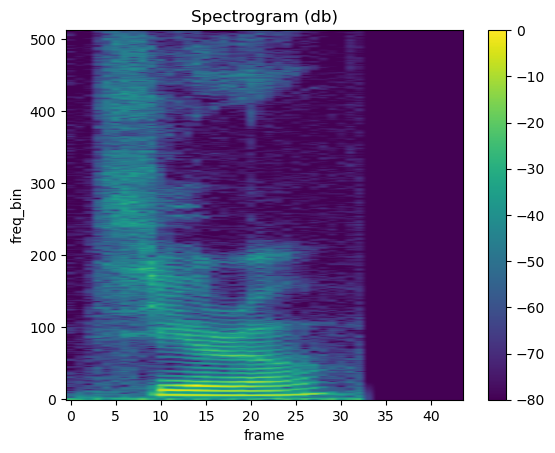

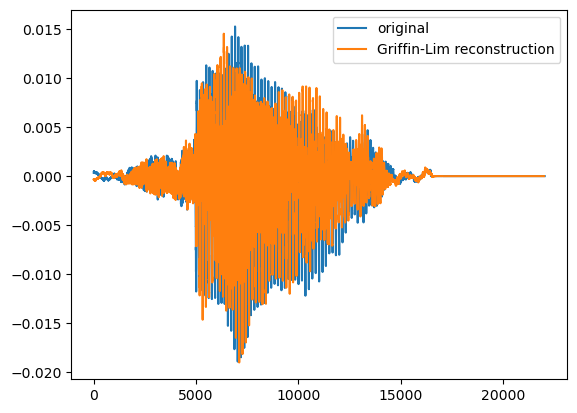

In [70]:
# Pre-processing (wav -> power spectrogram):
sig_orig,S,minmax=helpers.wav2powspec("test.wav")

# plot original and reconstructed signal
helpers.plot_spectrogram(S, title=None, ylabel="freq_bin")

# Post-processing (power spectrogram -> wav):
sig_recon=helpers.powspec2wave(S,orig_min=minmax["min"],orig_max=minmax["max"])

# plot original and reconstructed signal
plt.figure()
plt.plot(sig_orig,label='original')
plt.plot(sig_recon,label='Griffin-Lim reconstruction')
plt.legend()
plt.show()

# check how the reconstruction sounds
sf.write('test_reconstructed.wav', sig_recon.numpy().T, 22050, subtype='PCM_24')
Audio('test_reconstructed.wav')


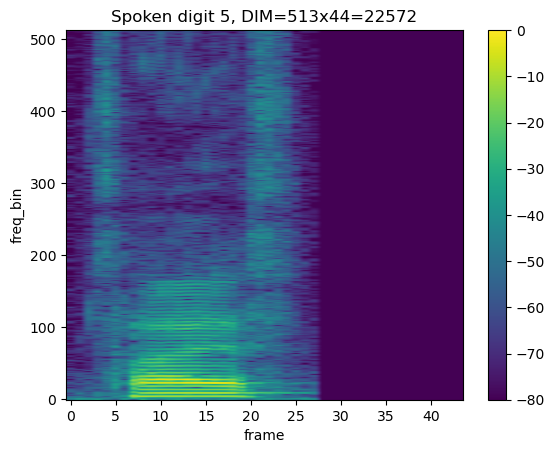

In [129]:
# Import my module with data loader which uses these preprocessing steps 
import torchdataset_prep as dsprep
importlib.reload(dsprep)

# Parameters of data loader
AUDIO_PATH = "/Users/joanna.luberadzka/Documents/AudioMNIST-data/data"
SAMPLE_RATE = 22050
SIG_LEN=1
SNR=100
N_SPK=60

# Parameters of data loader
dataset = dsprep.AudioMnistPowSpec(AUDIO_PATH, SAMPLE_RATE, SIG_LEN,N_SPK,SNR)
random_idx=np.random.randint(1,len(dataset))
data, label = dataset[random_idx]
# plot a random data point
helpers.plot_datapoint(data,label)
sig_recon=helpers.powspec2wave(data,orig_min=0,orig_max=5)
sf.write('reconstructed.wav', sig_recon.numpy().T, 22050, subtype='PCM_24')
Audio('reconstructed.wav')

In [131]:
# Import my module with model definition and training procedure
import training as TR
importlib.reload(TR)

# choose computing device
if torch.backends.mps.is_available():
    print("Using M1")
    device = torch.device("mps")
else:
    print("Using CPU")
    device = torch.device('cpu')

# split dataset into training set, test set and validation set
N_train = round(len(dataset) * 0.8)
N_rest = len(dataset) - N_train
trainset, restset = torch.utils.data.random_split(dataset, [N_train, N_rest])
N_test = round(len(restset) * 0.5)
N_val = len(restset) - N_test
testset, valset = torch.utils.data.random_split(restset, [N_test, N_val])

# create dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True, num_workers=2)

# instantiate a model
model=TR.AutoencoderConv()
summary(model,(1,513,44))
model.to(device)

# training
N_EPOCHS=10
outputs=TR.training(model, trainloader, N_EPOCHS, device,store_outputs=True)

# save model
torch.save(model.state_dict(), "../models/curr_model_snr"+str(SNR)+".pth")


Using M1
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 257, 22]             160
              ReLU-2          [-1, 16, 257, 22]               0
            Conv2d-3          [-1, 32, 129, 11]           4,640
              ReLU-4          [-1, 32, 129, 11]               0
            Conv2d-5             [-1, 64, 1, 1]       2,906,176
   ConvTranspose2d-6          [-1, 32, 129, 11]       2,906,144
              ReLU-7          [-1, 32, 129, 11]               0
   ConvTranspose2d-8          [-1, 16, 257, 22]           4,624
              ReLU-9          [-1, 16, 257, 22]               0
  ConvTranspose2d-10           [-1, 1, 513, 44]             145
          Sigmoid-11           [-1, 1, 513, 44]               0
Total params: 5,821,889
Trainable params: 5,821,889
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 

0it [00:00, ?it/s][W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.
3it [00:01,  1.94it/s][W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.
213it [01:22,  2.58it/s]


RuntimeError: Caught RuntimeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/anaconda3/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 61, in fetch
    return self.collate_fn(data)
  File "/opt/anaconda3/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/opt/anaconda3/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 143, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/opt/anaconda3/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 143, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/opt/anaconda3/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 120, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/opt/anaconda3/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 163, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [1, 513, 44] at entry 0 and [513, 44] at entry 52


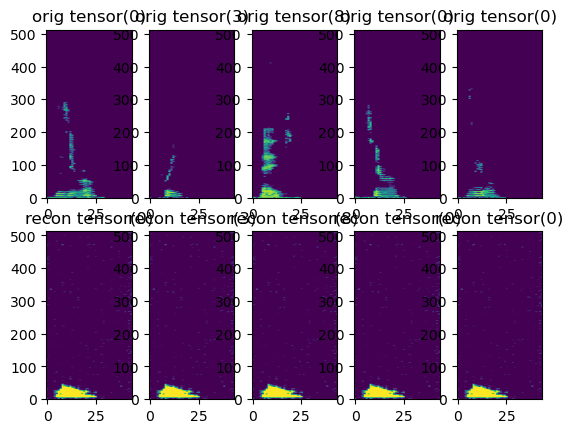

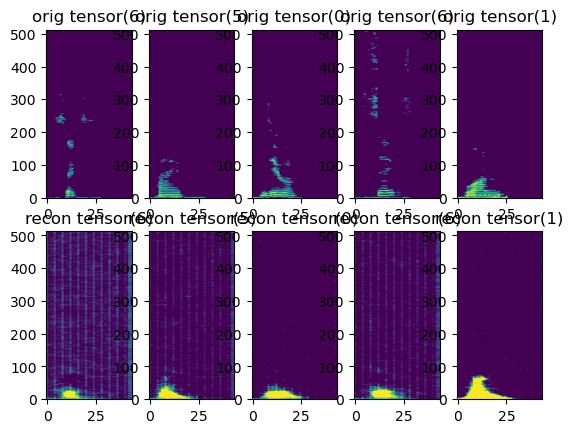

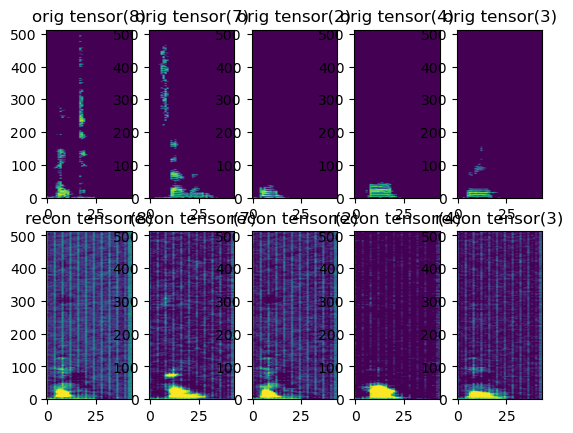

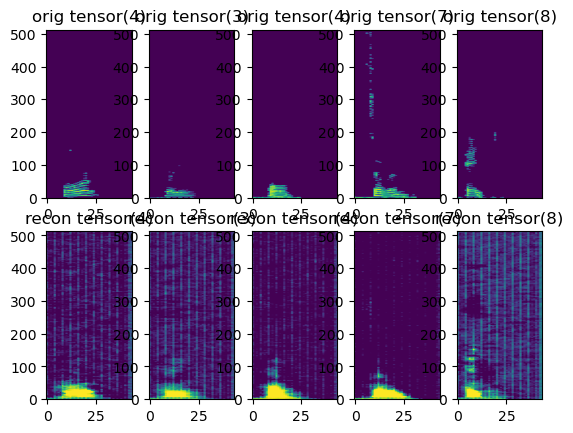

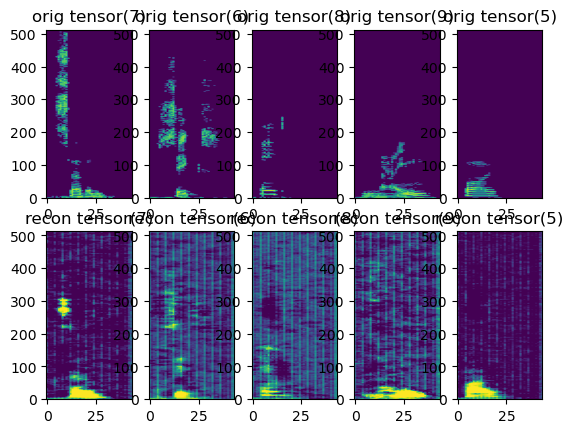

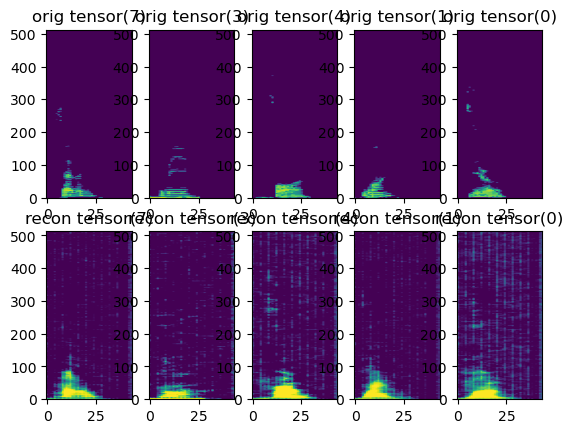

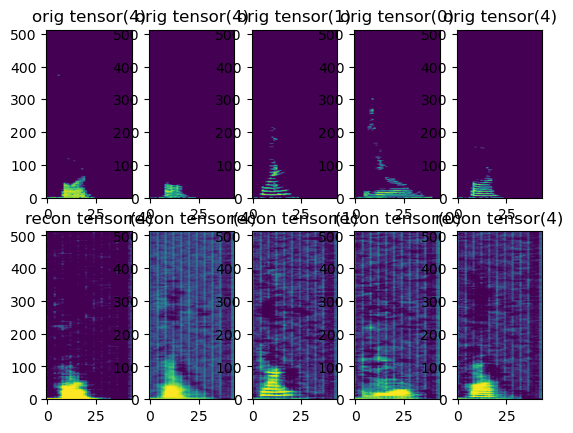

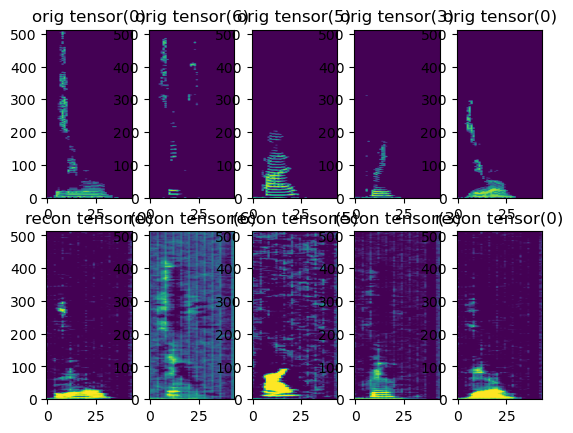

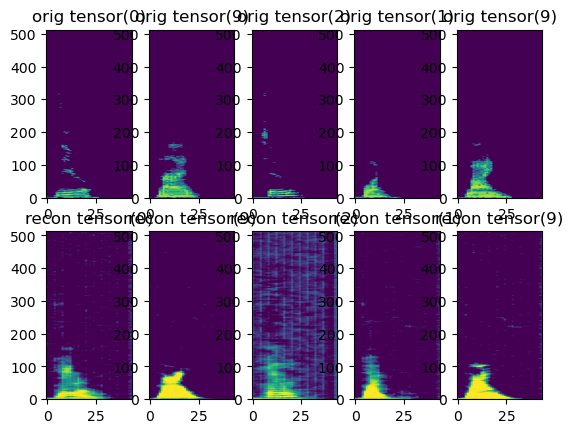

In [111]:
# test = print the reconstruction
n_examples=5
for i in range(0,9):
    fig, axs = plt.subplots(2,n_examples)
    x_orig=outputs[i][1]
    x_recon=outputs[i][2]
    x_label=outputs[i][3]
    for k in range(0,n_examples):
        x_orig_plot=torch.squeeze(x_orig[k].reshape(-1,513,44).detach()).cpu()
        x_recon_plot=torch.squeeze(x_recon[k].reshape(-1,513,44).detach()).cpu()
        x_label_plot=torch.squeeze(x_label[k].detach()).cpu()
        

        axs[0,k].set_title("orig "+ str(x_label_plot))
        axs[0,k].imshow(librosa.power_to_db(x_orig_plot), origin="lower", aspect="auto")
        
        axs[1,k].set_title("recon "+ str(x_label_plot))
        axs[1,k].imshow(librosa.power_to_db(x_recon_plot), origin="lower", aspect="auto")

        
    plt.show(block=False)

In [128]:
# Check how good is the reconstruction
FINAL_EPOCH=9
x_recon=outputs[FINAL_EPOCH][2]
x_label=outputs[FINAL_EPOCH][3]
rand_idx=np.random.randint(1,48)
x_recon_play=torch.squeeze(x_recon[rand_idx].reshape(-1,513,44).detach()).cpu()
x_label_play=torch.squeeze(x_label[rand_idx].detach()).cpu()
sig_recon=helpers.powspec2wave(x_recon_play,orig_min=0,orig_max=5)
sf.write('reconstructed.wav', sig_recon.numpy().T, 22050, subtype='PCM_24')


print("Original label: "+ str(x_label_play.numpy()))
Audio('reconstructed.wav')

Original label: 5


In [112]:
#1,16,3,2,1
O1=helpers.compute_cnn_out([1,513,44,1],[16,3,3,1],[1,1],[2,2])
print(O1)
O2=helpers.compute_cnn_out([1, 257.0, 22.0, 16],[32,3,3,16],[1,1],[2,2])
print(O2)
O3=helpers.compute_cnn_out([1, 129.0, 11.0, 32],[64,129,11,32],[0,0],[1,1])
print(O3)

[1, 257.0, 22.0, 16]
[1, 129.0, 11.0, 32]
[1, 1.0, 1.0, 64]
